In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import os

In [3]:
import sys 
sys.path.append('../')

In [4]:
import pandas as pd 
import numpy as np

In [5]:

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
 
from torch.utils.tensorboard import SummaryWriter


In [6]:
from src.utils.io.read import RawDataReader

In [7]:
from src.utils.io.read import RawDataReader

In [8]:
import  src.config as cfg 
from src.settings import Settings

In [9]:
rdr = RawDataReader(raw_data_directory=Settings.backfill.paths.RAW_DATA_PATH)

In [10]:
equity_data = rdr.read_30_equities()

In [11]:
equity_data=equity_data[['tradeDate', 'ClosePrice', 'Ticker']].dropna().reset_index(drop=True)

In [12]:
equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'], errors='coerce').dt.date
equity_data['ClosePrice'] = pd.to_numeric(equity_data['ClosePrice'], errors='coerce')


In [13]:
equity_data.dropna(inplace = True) 

In [14]:
equity_data.sort_values(by ='tradeDate', ascending = True, inplace = True)

In [15]:
equity_data['prior_1D_return'] = equity_data['ClosePrice']/ equity_data.groupby('Ticker')['ClosePrice'].shift(1)-1

In [16]:
equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'] ).dt.date

In [17]:
data = equity_data.pivot_table(index= 'tradeDate', 
                               columns = 'Ticker',
                               values = 'prior_1D_return').dropna(axis=1, 
                                                 how='all').dropna(axis=0,
                                                                   how='all').fillna(0)

In [18]:
data =  np.array(data) 

In [19]:
data.shape

(1365, 32)

In [20]:
data

array([[ 0.00796826, -0.00433387,  0.00294507, ..., -0.00215232,
        -0.00203579,  0.00767809],
       [-0.00470314, -0.0052394 ,  0.01060706, ..., -0.01111664,
        -0.00926646, -0.008184  ],
       [ 0.01608633,  0.01725954, -0.01752253, ...,  0.00184564,
        -0.00343085, -0.01508038],
       ...,
       [ 0.01639835,  0.02199622,  0.00851593, ...,  0.01154734,
        -0.00500204,  0.0239615 ],
       [-0.01211259, -0.00300856,  0.03183112, ..., -0.00342466,
        -0.00020519,  0.00671334],
       [ 0.00605609, -0.00676482, -0.00818353, ...,  0.01099656,
        -0.00133402,  0.0214347 ]])

In [21]:
from src.models.diffusion.ddpm import ScoreNet, DDPM

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [22]:
def train_ddpm(model, data, ddpm, epochs=10000, batch_size=128, lr=1e-3):
    """Train the DDPM model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    # Convert data to tensor
    data_tensor = torch.from_numpy(data).to(device)
    n_samples = len(data_tensor)
    
    losses = []
    
    for epoch in range(epochs):
        epoch_losses = []
        
        # Mini-batch training
        for i in range(0, n_samples, batch_size):
            batch = data_tensor[i:i+batch_size]
            
            # Sample random timesteps
            t = torch.randint(0, ddpm.timesteps, (len(batch),)).to(device)
            
            # Add noise
            x_t, noise = ddmp.add_noise(batch, t)
            
            # Predict noise
            predicted_noise = model(x_t, t)
            
            # Compute loss (simple MSE)
            loss = nn.MSELoss()(predicted_noise, noise)
            
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return losses

# ==================== Visualization ====================

def plot_results(original_data, generated_data, title="Results"):
    """Plot original vs generated data"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original data
    ax1.scatter(original_data[:, 0], original_data[:, 1], alpha=0.6, s=20)
    ax1.set_title("Original Spiral Data")
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    
    # Generated data
    ax2.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.6, s=20, color='red')
    ax2.set_title("Generated Data")
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==================== Main Execution ====================


In [25]:
data = data.astype(np.float32) #generate_spiral_data(n_samples=2000)

# Initialize model and DDPM
model = ScoreNet(input_dim=32, hidden_dim=256, time_dim=32).to(device)
ddmp = DDPM(timesteps=5000)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

# Train model
print("\nTraining DDPM...")
losses = train_ddpm(
    model=model,
    data= data,
    ddpm=ddmp,
    epochs=10000,
    batch_size=128,
    lr=1e-3
)




Model has 157568 parameters

Training DDPM...
Epoch 100/10000, Loss: 0.0358
Epoch 200/10000, Loss: 0.0239
Epoch 300/10000, Loss: 0.0177
Epoch 400/10000, Loss: 0.0123
Epoch 500/10000, Loss: 0.0074
Epoch 600/10000, Loss: 0.0089
Epoch 700/10000, Loss: 0.0076
Epoch 800/10000, Loss: 0.0061
Epoch 900/10000, Loss: 0.0056
Epoch 1000/10000, Loss: 0.0070
Epoch 1100/10000, Loss: 0.0066
Epoch 1200/10000, Loss: 0.0050
Epoch 1300/10000, Loss: 0.0061
Epoch 1400/10000, Loss: 0.0064
Epoch 1500/10000, Loss: 0.0049
Epoch 1600/10000, Loss: 0.0064
Epoch 1700/10000, Loss: 0.0055
Epoch 1800/10000, Loss: 0.0052
Epoch 1900/10000, Loss: 0.0057
Epoch 2000/10000, Loss: 0.0055
Epoch 2100/10000, Loss: 0.0054
Epoch 2200/10000, Loss: 0.0050
Epoch 2300/10000, Loss: 0.0057
Epoch 2400/10000, Loss: 0.0060
Epoch 2500/10000, Loss: 0.0043
Epoch 2600/10000, Loss: 0.0066
Epoch 2700/10000, Loss: 0.0052
Epoch 2800/10000, Loss: 0.0063
Epoch 2900/10000, Loss: 0.0034
Epoch 3000/10000, Loss: 0.0047
Epoch 3100/10000, Loss: 0.0047
Ep

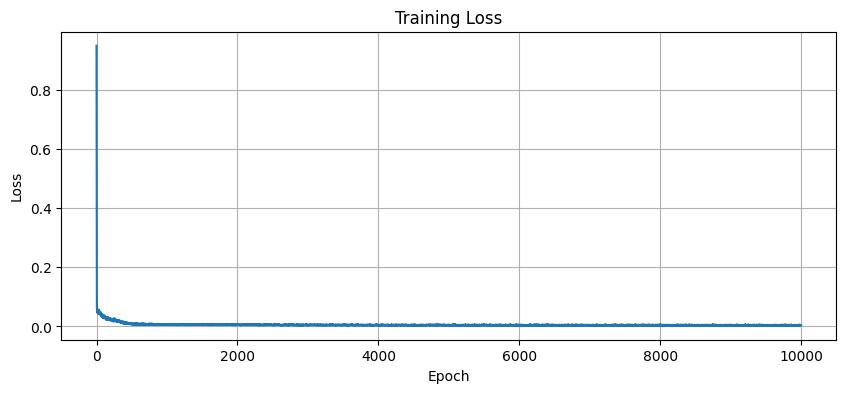

In [26]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()


In [ ]:
# Generate samples
print("\nGenerating samples...")
n_generate = 10000
generated_samples = ddmp.sample(model, n_generate).cpu().numpy()


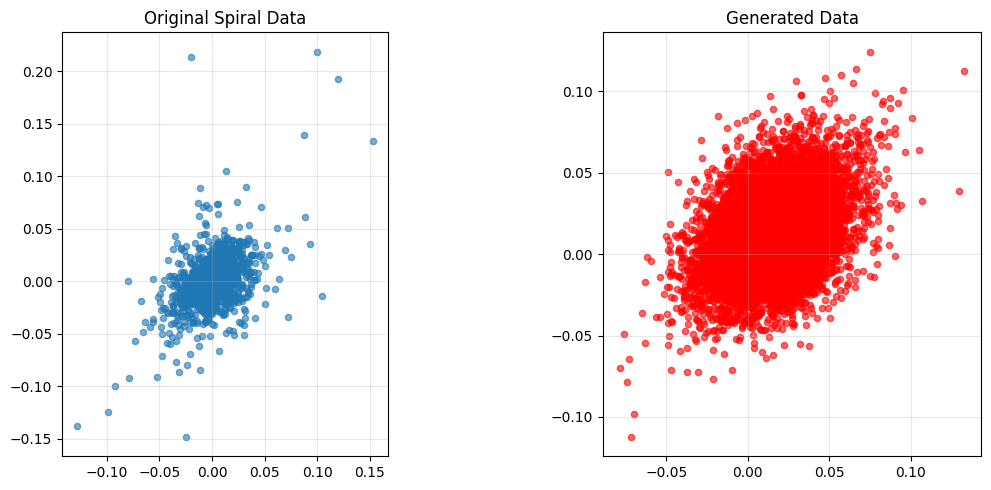

In [30]:

# Visualize results
plot_results(data[:n_generate], generated_samples)



In [29]:
# Print statistics
print("\n=== Statistics ===")
print(f"Original - Mean: {data.mean():.3f}, Std: {data.std():.3f}")
print(f"Generated - Mean: {generated_samples.mean():.3f}, Std: {generated_samples.std():.3f}")




=== Statistics ===
Original - Mean: 0.001, Std: 0.022
Generated - Mean: 0.005, Std: 0.023


In [31]:
from research.plots import qqplot, qqplot_against_normal

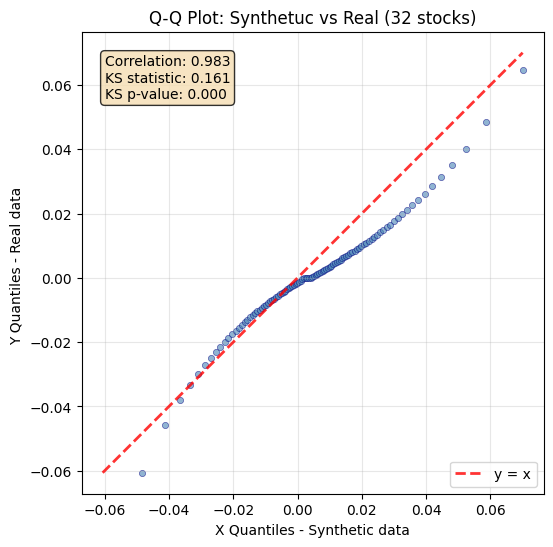

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Flatten the arrays (concatenate all columns)
synthetic_flat = generated_samples.flatten()
real_flat = data.flatten()

_=qqplot(x=synthetic_flat , 
         y=real_flat,
        title  = 'Q-Q Plot: Synthetuc vs Real (32 stocks)',
    xlabel  = 'X Quantiles - Synthetic data',
    ylabel  = 'Y Quantiles - Real data ',)
plt.show()
plt.close()

In [33]:
np.linalg.cond(pd.DataFrame(generated_samples).cov())

40.199800414496934

In [34]:
np.linalg.cond(pd.DataFrame(data).cov())

113.73615544814133